In [1]:
import os
import torch
import torchvision
import PIL
import importlib
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import classification_report
#
import datasetconf as DC
import TaskClass as TaskClass
import Task as Task
import TestNets as TestNets
import maml as MAML
#
_ = importlib.reload(DC)
_ = importlib.reload(TaskClass)
_ = importlib.reload(Task)
_ = importlib.reload(TestNets)
_ = importlib.reload(MAML)

In [2]:
task1 = Task.create_task_given(
    task_friendly_name='Task1',
    dataset_name='boat',
    class_names=['Gondola', 'Motopontonerettangolare'], #n-way
    len_support_dataset=3, #k-shot
    len_query_dataset=2,   #k-shot
    let_test_dataset=5, # Number of test cases per class
    transformer=torchvision.transforms.Compose([
        torchvision.transforms.Resize(224),
        torchvision.transforms.CenterCrop(224),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225])]),
    img_size=224,
    start_class_id=0)
task1.reset_train_session()
#
task2 = Task.create_task_given(
    task_friendly_name='Task2',
    dataset_name='boat',
    class_names=['Raccoltarifiuti', 'Water'],
    len_support_dataset=3,
    len_query_dataset=2,
    let_test_dataset=5, # Number of test cases per class
    transformer=torchvision.transforms.Compose([
        torchvision.transforms.Resize(224),
        torchvision.transforms.CenterCrop(224),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225])]),
    img_size=224,
    start_class_id=2)
task2.reset_train_session()
#
TASKS = [task1, task2]
LEN_CLASSES = sum(len(task.task_classes) for task in TASKS)
CLASSES_NAMES = [taskclass.class_friendly_name for task in TASKS for taskclass in task.task_classes]
NUM_IN_CHANNELS = 3 # RGB

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
tensor([1, 0, 1, 0])
torch.Size([6, 3, 224, 224])
torch.Size([6])


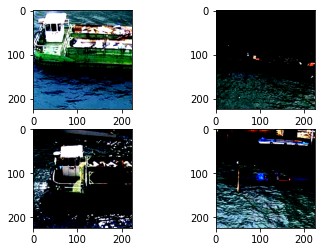

In [3]:
plt.subplot(221)
plt.imshow(task1.supp_train[0].permute(1, 2, 0))
plt.subplot(222)
plt.imshow(task1.supp_train[1].permute(1, 2, 0))
plt.subplot(223)
plt.imshow(task1.supp_train[2].permute(1, 2, 0))
plt.subplot(224)
plt.imshow(task1.supp_train[3].permute(1, 2, 0))
#
print(task1.supp_targets[:4])
print(task1.supp_train.shape)
print(task1.supp_targets.shape)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
tensor([2, 3, 2, 3])
torch.Size([6, 3, 224, 224])
torch.Size([6])


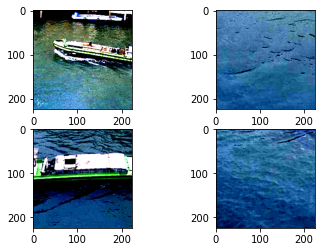

In [4]:
plt.subplot(221)
plt.imshow(task2.supp_train[0].permute(1, 2, 0))
plt.subplot(222)
plt.imshow(task2.supp_train[1].permute(1, 2, 0))
plt.subplot(223)
plt.imshow(task2.supp_train[2].permute(1, 2, 0))
plt.subplot(224)
plt.imshow(task2.supp_train[3].permute(1, 2, 0))
#
print(task2.supp_targets[:4])
print(task2.supp_train.shape)
print(task2.supp_targets.shape)

In [5]:
def simple_test():
    test_net.eval()
    for task in TASKS:
        task.reset_test_session()
        preds_softmax = test_net(task.test_train)
        preds = torch.argmax(preds_softmax, dim=1)
        correct = torch.sum(preds == task.test_targets).item()
        print(task.task_friendly_name, correct * 100 / task.test_targets.shape[0])
        print(classification_report(task.test_targets, preds, target_names=CLASSES_NAMES, labels=range(LEN_CLASSES)))
        print()

In [6]:
test_net = TestNets.TestNet224x224(n_channels_in=NUM_IN_CHANNELS, n_classes=LEN_CLASSES)

In [7]:
simple_test()

Task1 0.0
                         precision    recall  f1-score   support

                Gondola       0.00      0.00      0.00       3.0
Motopontonerettangolare       0.00      0.00      0.00       3.0
        Raccoltarifiuti       0.00      0.00      0.00       0.0
                  Water       0.00      0.00      0.00       0.0

               accuracy                           0.00       6.0
              macro avg       0.00      0.00      0.00       6.0
           weighted avg       0.00      0.00      0.00       6.0


Task2 50.0
                         precision    recall  f1-score   support

                Gondola       0.00      0.00      0.00         0
Motopontonerettangolare       0.00      0.00      0.00         0
        Raccoltarifiuti       0.00      0.00      0.00         5
                  Water       0.50      1.00      0.67         5

              micro avg       0.50      0.50      0.50        10
              macro avg       0.12      0.25      0.17        1

In [8]:
test_net.eval()
for task in TASKS:
    task.reset_test_session()
    preds_softmax = test_net(task.test_train)
    preds = torch.argmax(preds_softmax, dim=1)
    correct = torch.sum(preds == task.test_targets).item()
    print(task.task_friendly_name, correct * 100 / task.test_targets.shape[0])

Task1 0.0
Task2 60.0


In [9]:
MAML.maml_nn_classifier_learn(
    test_net=test_net,
    tasks=TASKS,
    # inner_epochs: int = 1, # Not implemented yet.
    meta_epochs=20,
    # inner_lr: float = 0.001,
    # outer_lr: float = 0.001,
    # loss_function = torch.nn.CrossEntropyLoss()
)

In [10]:
simple_test()

Task1 66.66666666666667
                         precision    recall  f1-score   support

                Gondola       0.67      0.67      0.67         3
Motopontonerettangolare       1.00      0.67      0.80         3
        Raccoltarifiuti       0.00      0.00      0.00         0
                  Water       0.00      0.00      0.00         0

              micro avg       0.67      0.67      0.67         6
              macro avg       0.42      0.33      0.37         6
           weighted avg       0.83      0.67      0.73         6


Task2 40.0
                         precision    recall  f1-score   support

                Gondola       0.00      0.00      0.00         0
Motopontonerettangolare       0.00      0.00      0.00         0
        Raccoltarifiuti       0.00      0.00      0.00         5
                  Water       0.50      0.80      0.62         5

              micro avg       0.40      0.40      0.40        10
              macro avg       0.12      0.20     

In [11]:
# from collections import OrderedDict
# import copy

# # NOTE: this only does one epoch of SGD per support dataset: more epochs?

# test_net.train()

# for _ in range(10):
#     backup_named_parameters = test_net.named_parameters
#     outer_loss = 0
#     meta_optimiser.zero_grad()
#     test_net.zero_grad()
#     for task in TASKS:
#         #
#         supp_train_inner_loss = loss_function(test_net(task.supp_train), task.supp_targets)
#         #
#         test_net.zero_grad()
#         grads = torch.autograd.grad(supp_train_inner_loss, test_net.parameters(), create_graph=True)
#         #
#         named_params = OrderedDict()
#         for (pname, param), grad in zip(test_net.named_parameters(), grads):
#             named_params[pname] = optimiser(param, grad)
#         #
#         test_net.named_parameters = named_params
#         query_tr_inner_loss = loss_function(test_net(task.query_train), task.query_targets)
#         test_net.named_parameters = backup_named_parameters
#         #
#         outer_loss += query_tr_inner_loss # mul with alpha
#     #
#     outer_loss.backward() # add final loss here L(Alg(theta, Dtr), Dval)
#     meta_optimiser.step()